<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_lunalander_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
#!sudo pip install box2d-py
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

test

In [3]:
p = build_policy(nn.HybridSequential(),2)
p.initialize(init=init.Xavier())
x = nd.random.normal(shape=(1,4))
p(x)


[[-0.00842177  0.05223081]]
<NDArray 1x2 @cpu(0)>

# hyperparams

In [0]:
# env
seed = 42
game = 'LunarLander-v2'
env = gym.make(game)
env.seed(seed)

# policy net
policy_net = build_policy(nn.HybridSequential(),env.action_space.n)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())

# trainer
trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':1e-3})

# game params
max_episode_num = 1000
max_steps = 1000

# log list
all_rewards = []
avg_all_rewards = []

# main loop

0 -161.56060147530553
10 -139.70962190330866
20 -204.1217677967515
30 -218.79923366012113
40 -122.4414791600608
50 -157.8848586053546
60 -135.23650865258
70 -118.06182462241539
80 -128.56971281030556
90 -123.97079039267103
100 -104.66817762063988
110 -167.48635522024492
120 -78.29350317932133
130 -100.23997865662818
140 -61.3885890480401
150 -40.46416841946542
160 -57.54317539070602
170 -156.43643832989753
180 -49.97074662680915
190 -15.594581151692859
200 -28.983176609767053
210 51.30766429906375
220 -166.94248359925825
230 20.362270918244327
240 -20.22006637098344
248 229.8922433304934 solved


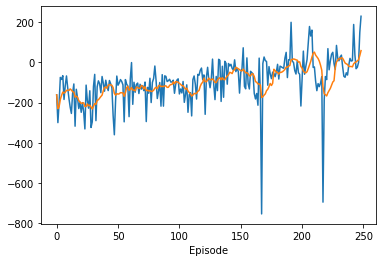

In [5]:
for episode in range(max_episode_num):
  state = env.reset()
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      
      state, reward, done, _ = env.step(action.asnumpy()[0])
      
      # reward engineering
      #angle_bias = abs(state[2]-0)
      #pos_bias = abs(state[0]-0)
      #reward -= 0.1*angle_bias + 0.1*pos_bias
      
      # store memory
      log_probs.append(log_prob)
      rewards.append(reward)
      
      if done:
        break
    
    # logging
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() #+ np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(1)
  
  # print info
  if episode % 10 == 0:
    print(episode,avg_all_rewards[-1])
  
  # if solved
  if all_rewards[-1] >= 200:
    print(episode,all_rewards[-1],'solved')
    best_episode = episode
    break

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export(game,epoch=best_episode)

In [0]:
del policy_net

In [8]:
deserialized_net = nn.SymbolBlock.imports("{}-symbol.json".format(game), 
                                          ['data'], 
                                          "{}-0{}.params".format(game,best_episode))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [11]:

env = gym.make(game)
env.seed(seed)

policy_net = deserialized_net

for episode in range(10):
  state = env.reset()
  rewards = []
  for t in range(1000):
    state = nd.array(np.expand_dims(state, 0))
    
    probs = nd.softmax(policy_net(state))
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    
    state, reward, done, _ = env.step(action.asnumpy()[0])
    
    rewards.append(reward)
    if done:
      break
  
  # print info
  print(episode,np.sum(rewards))

0 12.820941932372598
1 218.1311028100509
2 -54.079286186522104
3 -47.35889015577739
4 -20.89030665933163
5 -35.76102205102549
6 -41.39320712194609
7 -39.0867085982043
8 179.77102332788627
9 -12.373201205835421
